#### For Colab

In [2]:
"""
function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button").click() 
}
var i = setInterval(ClickConnect, 900000)
clearInterval(i)
"""

'\nfunction ClickConnect(){\n    console.log("Working");\n    document.querySelector("colab-toolbar-button").click() \n}\nvar i = setInterval(ClickConnect, 900000)\nclearInterval(i)\n'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
drive_dir = '/content/drive/My Drive/MAGMA: Summarization/'

#### Install Libraries

In [5]:
!pip install transformers==4.1.1
!pip install -U sentencepiece!=0.1.92
!pip install -U datasets
!pip install rouge_score

     |████████████████████████████████| 1.5MB 18.5MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
     |████████████████████████████████| 2.9MB 50.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=e5bee4816eb3992f0db9b0e85c5c8cdb8d75f129a4ec25bd3b27f5476a29d83a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 28.8MB/s 
     |████████████████████████████████| 163kB 14.6MB/s 
     |████████████████████████████████| 245kB 31.0MB/s 
     |████████████████████████████████| 17.7MB 194kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


### **Config**

In [6]:
import os
import sys

sys.path.insert(0, drive_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [7]:
MODEL = 'bart'
MODELS = {}

### **Init**

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill

### **Function Definition**

##### Import Model and Tok

In [9]:
def import_model_tok(model_name_or_path):
    global MODELS

    if model_name_or_path in MODELS.keys():
        print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    MODELS[model_name_or_path] = model, tokenizer
    print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Nice Print

In [10]:
def print_example(text, summ, bull):
    print(fill(text, 150))
    print()
    print('Prediction:')
    print(fill(summ, 100))
    print()
    print('Reference:')
    print(fill(bull, 100))
    print()
    print(''.join(['#']*100))
    print()

## **Summarization experiments**

##### Model writing the opposite of input

In [16]:
def summarize(model_name_or_path, text, bullets):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    summ_enc = model.generate(
        tokenizer.encode(text, return_tensors='pt').to(device),
        max_length = config.ONE_BULLET_MAX_LEN)[0]
    summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

    print_example(text, summ, bullets)

In [17]:
text = 'Long-term risks. As with any form of chronic UV exposure, it is likely that phototherapy carries an increased risk of non-melanoma skin cancers, which increases with cumulative exposure. Broad-band UVB is probably associated with a small increase in the risk of squamous cell carcinomas, particularly in patients receiving high-level exposure (more than 300 treatments). Narrow-band UVB phototherapy has now been in clinical use for long enough to determine the associated risk precisely. On the basis of cancer-risk calculations from mouse models and efficacy data, it seems likely that the risk is at least as great as that associated with broad-band UVB, but probably less than that associated with PUVA. In view of this, phototherapy may be relatively contraindicated for patients with pre-existing risk factors for skin cancer, such as individuals who work outside, those who have already had significant amounts of phototherapy, patients with very fair skin, and those with multiple melanocytic or atypical nevi.'
bullets = 'Long-term risks of PUVA include premature skin aging and skin cancer (non-melanoma and melanoma).'

In [18]:
summarize('facebook/bart-large-cnn', text, bullets)

[+] model already present in cache

Long-term risks. As with any form of chronic UV exposure, it is likely that phototherapy carries an increased risk of non-melanoma skin cancers, which
increases with cumulative exposure. Broad-band UVB is probably associated with a small increase in the risk of squamous cell carcinomas, particularly
in patients receiving high-level exposure (more than 300 treatments). Narrow-band UVB phototherapy has now been in clinical use for long enough to
determine the associated risk precisely. On the basis of cancer-risk calculations from mouse models and efficacy data, it seems likely that the risk
is at least as great as that associated with broad-band UVB, but probably less than that associated with PUVA. In view of this, phototherapy may be
relatively contraindicated for patients with pre-existing risk factors for skin cancer, such as individuals who work outside, those who have already
had significant amounts of phototherapy, patients with very fair skin,

In [21]:
summarize(drive_dir+'fine-tuning/bart_karger_books_para_train', text, bullets)

[+] model already present in cache

Long-term risks. As with any form of chronic UV exposure, it is likely that phototherapy carries an increased risk of non-melanoma skin cancers, which
increases with cumulative exposure. Broad-band UVB is probably associated with a small increase in the risk of squamous cell carcinomas, particularly
in patients receiving high-level exposure (more than 300 treatments). Narrow-band UVB phototherapy has now been in clinical use for long enough to
determine the associated risk precisely. On the basis of cancer-risk calculations from mouse models and efficacy data, it seems likely that the risk
is at least as great as that associated with broad-band UVB, but probably less than that associated with PUVA. In view of this, phototherapy may be
relatively contraindicated for patients with pre-existing risk factors for skin cancer, such as individuals who work outside, those who have already
had significant amounts of phototherapy, patients with very fair skin,

### **Print and Summarization**

##### Print Train Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_train)

[*] importing the model




[+] the model is now present in cache

(9781912776696, 'hh-5')
Kaplan-Meier survival curves are often used to compare the data between two groups of subjects. Figure 2.2 shows Kaplan-Meier curves for OS in a
randomized study of patients with human epidermal growth factor receptor 2 (HER2)-positive metastatic breast cancer treated either with or without
trastuzumab. The Kaplan-Meier curve steps down at time points at which deaths occur, while censored observations are denoted by notches on the curve.
In this study, the follow-up period ranged from 3 months to 74 months. The Kaplan-Meier curve plots the probability of being event free over time,
with these probabilities being estimated from the data in the study. Note that the curve for patients who received trastuzumab is consistently above
the curve for those who did not receive trastuzumab, indicating a higher survival probability in that group.

Prediction:
 Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study of patien

##### Print Val Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_val)

[+] model already present in cache

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of low back pain syndromes. The most common causes of
low back pain are mechanical in origin. Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal structure.
The most important traumatic factors in low back pain relate to soft tissue structures. Precise identification of the injured tissue, and the role of
that injury in the consequent pain and dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet joints,
ligaments or spinal nerves. Aging causes modification of these structures over time, and different parts of the spine tend to be at greater risk for
change or injury during different decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the sixth decade of
life (Table 3.1).

Prediction:
 Mechanical di

##### Print Test Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_test)

[+] model already present in cache

(9781908541277, 'ch_8')
After a hiatus of nearly 20 years, 16 new AEDs and two devices - the vagus nerve stimulator and deep brain stimulator - have received licenses for the
adjunctive treatment of refractory epilepsy, the last so far only in Europe. Gabapentin (GBP), lacosamide (LCM), LTG, levetiracetam (LEV),
oxcarbazepine (OXC), pregabalin (PGB), tiagabine (TGB), TPM and zonisamide (ZNS) are widely available for partial seizures. Rufinamide (RFN) has been
licensed in Europe and the USA for adjunctive treatment of seizures in Lennox-Gastaut syndrome. Eslicarbazepine acetate (ESL) is licensed in Europe as
adjunctive treatment for partial seizures with or without secondary generalization. Retigabine (RTG; ezogabine in the USA) and perampanel (PER) have
recently been approved for use in Europe and the USA for the same indication. After 20 years of global experience, vigabatrin (VGB) has been approved
in the USA for the treatment of infantile spasms a

##### Summarize Test

In [ ]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [ ]:
df_test = summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

[+] model already present in cache

100%|██████████| 25/25 [01:26<00:00,  3.45s/it]


### **Evaluation**

In [ ]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [ ]:
def evaluate_model(df, model_name_or_path):
    rouge_res =\
        df[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
    
    df_save = df[[c for c in df_test.columns if c.startswith('rouge')]]
    df_save.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [ ]:
df_test = evaluate_model(df_test, 'sshleifer/distilbart-cnn-12-6')

##### Plot Evaluation

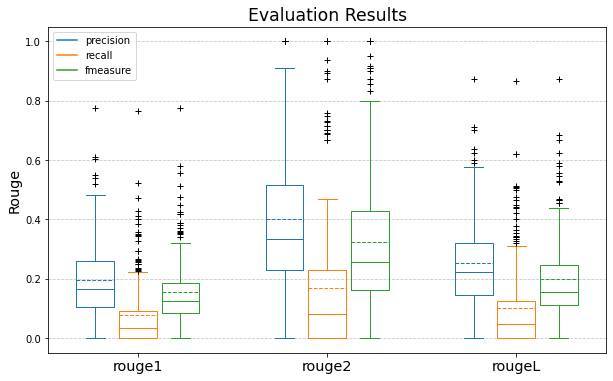

In [ ]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')